In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt

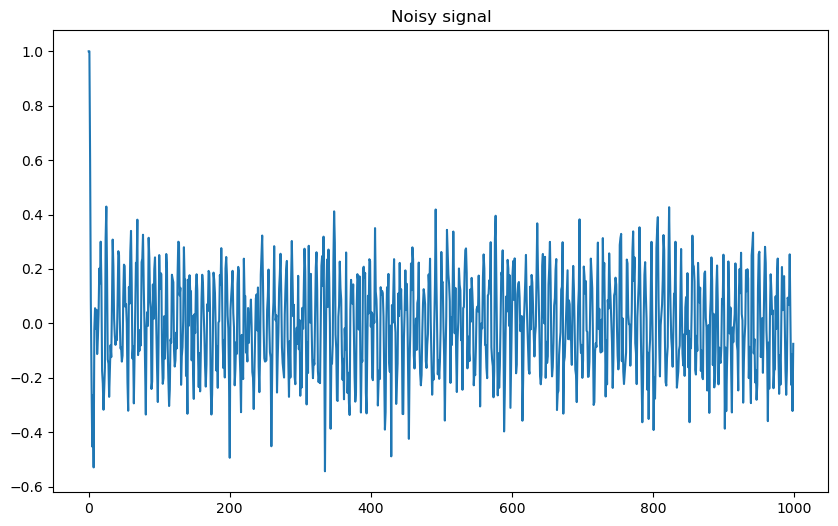

In [2]:
# Load and plot the noisy signal
x = np.load('noisy_dataS_Cr2_noise=0.1_Tmax=1000_overlap=0.2_dt=1.npy')
plt.figure(figsize=(10, 6))
plt.plot(x.real)
plt.title("Noisy signal")
plt.show()

In [3]:
# FFT
X_fft = scipy.fft.fft(x)
X_fft_shifted = scipy.fft.fftshift(X_fft)
frequencies = scipy.fft.fftshift(scipy.fft.fftfreq(len(x), d=1))

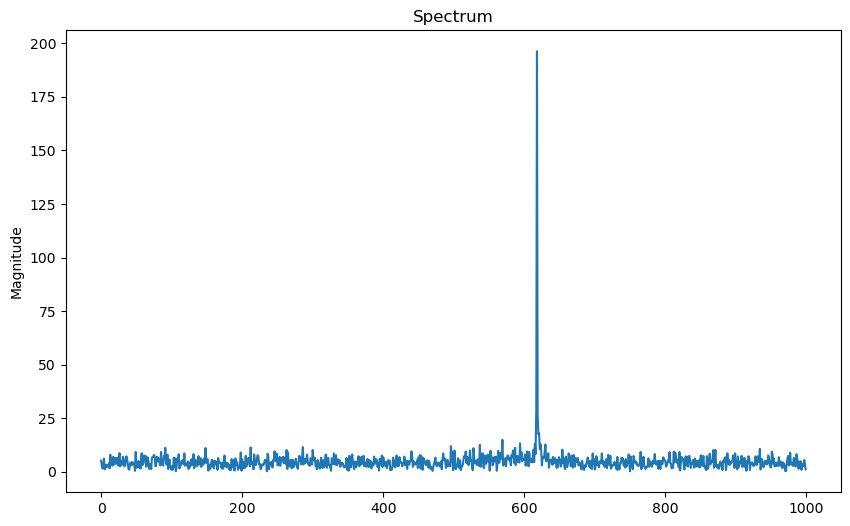

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(np.abs(X_fft_shifted))
plt.title("Spectrum")
plt.ylabel("Magnitude")
plt.show()

In [5]:
# Based on spectrum, pick area where no large peak is 
noise_region = np.abs(X_fft_shifted)[100:200]  
noise_level = np.mean(noise_region)  

In [6]:
# Thresholding
threshold_factor = 3 
threshold = threshold_factor * noise_level

In [7]:
# Zero out frequencies below the threshold
X_fft_filtered = X_fft_shifted * (np.abs(X_fft_shifted) > threshold)
# IFFT to obtain the denoised signal
x_denoised = scipy.fft.ifft(scipy.fft.ifftshift(X_fft_filtered))
# We know s(0) = 1 
x_denoised[0] = 1.0

In [8]:
# Load the noiseless data
x_true = np.load('noiseless_dataS_Cr2_noise=0.1_Tmax=1000_overlap=0.2_dt=1.npy')

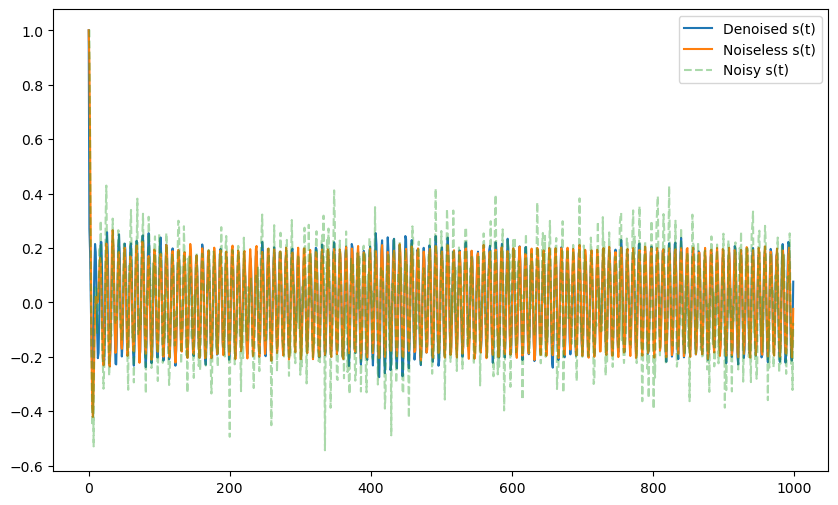

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(x_denoised.real, label="Denoised s(t)")
plt.plot(x_true.real, label="Noiseless s(t)")
plt.plot(x.real, alpha=0.4, label="Noisy s(t)", linestyle='--')
plt.legend()

In [10]:
# MAE
print('MAE (GT): ', np.mean(np.abs(x_denoised.real - x_true.real)))
print('MAE (N): ', np.mean(np.abs(x.real - x_denoised.real)))

MAE (GT):  0.026668997858774583
MAE (N):  0.08410965192418883


In [23]:
from scipy.io import savemat
denoised_filename = f'./matlab/noisy_data/denoised_dataS_Cr2_noise=0.1_Tmax=1000_overlap=0.2_dt=1.mat'
savemat(denoised_filename, {'dataS': x_denoised})

In [11]:
# Bandpass filtering

In [12]:
# Pick range based on known bounds of the spectrum
lower_bound = -np.pi/4 - 0.2
upper_bound = np.pi/4 + 0.2
lower_bound_hz = lower_bound / (2 * np.pi)
upper_bound_hz = upper_bound / (2 * np.pi)

In [13]:
#FFT
X_fft = scipy.fft.fft(x)
X_fft_shifted = scipy.fft.fftshift(X_fft)

In [14]:
# Bandpass filter 
band_pass_mask = (frequencies >= lower_bound_hz) & (frequencies <= upper_bound_hz)
X_fft_filtered = X_fft_shifted * band_pass_mask

Text(0, 0.5, 'Magnitude')

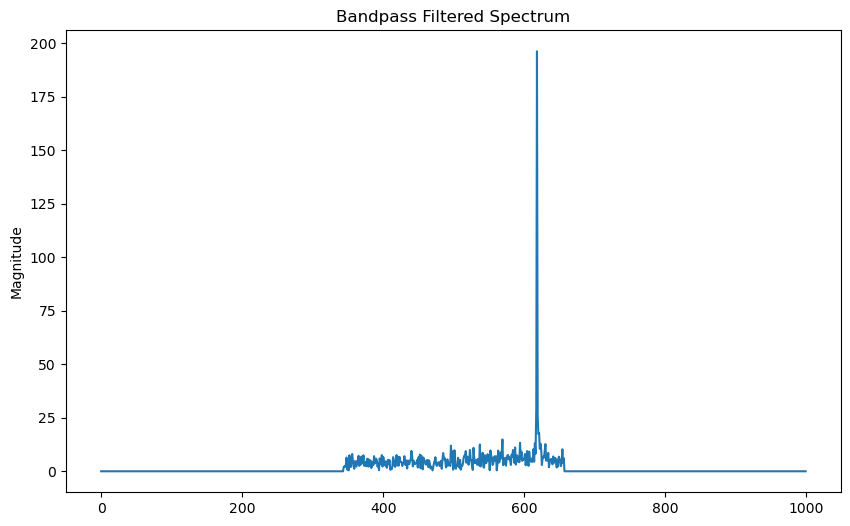

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(np.abs(X_fft_filtered))
plt.title("Bandpass Filtered Spectrum")
plt.ylabel("Magnitude")

In [16]:
# IFFT to recover s(t)
x_filtered = scipy.fft.ifft(scipy.fft.ifftshift(X_fft_filtered))
x_filtered[0] = 1.0

MAE (GT):  0.04650049035489945
MAE (N):  0.06986148308260798


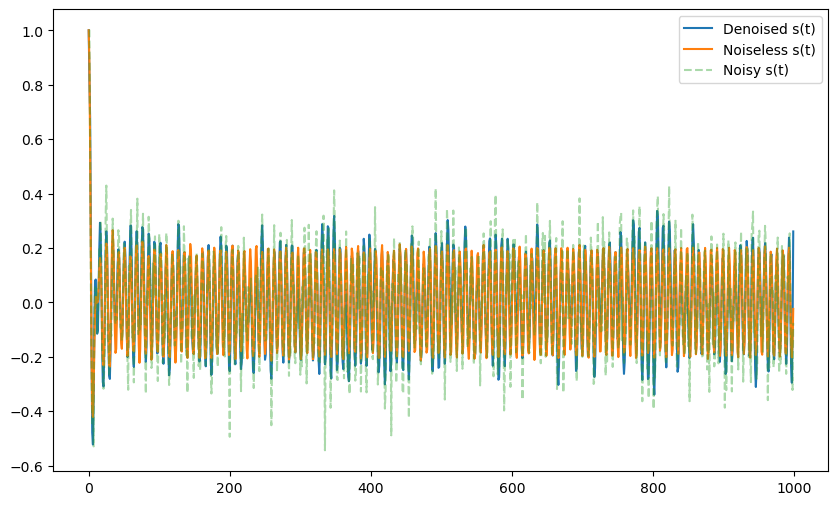

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(x_filtered.real, label="Denoised s(t)")
plt.plot(x_true.real, label="Noiseless s(t)")
plt.plot(x.real, alpha=0.4, label="Noisy s(t)", linestyle='--')
plt.legend()
print('MAE (GT): ', np.mean(np.abs(x_filtered.real - x_true.real)))
print('MAE (N): ', np.mean(np.abs(x.real - x_filtered.real)))